In [230]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [231]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## 2D dataset

In [232]:
# num_points = 100
# # X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
# # X2 = np.linspace(-2.2, 2.1, num_points)
# X1, X2 = np.meshgrid(X1, X2)

# # Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

# ####Scaling the data to range -1,1
# X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
# X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
# Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1


In [233]:
# x1 = X1.reshape(-1)
# x2 = X2.reshape(-1)
# y = Y.reshape(-1)

# xx = torch.Tensor(np.c_[x1, x2])
# yy = torch.Tensor(Y.reshape(-1,1))

# %matplotlib inline
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(X1, X2, Y, cmap='plasma')
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# plt.show()

In [234]:
# SEED = 4

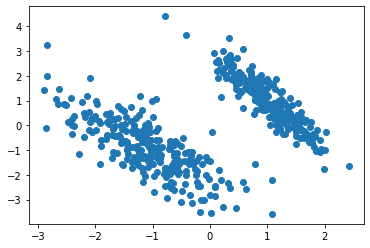

In [235]:
# print(SEED)
np.random.seed(19) # 7, 10, 17, 19
xx, yy = datasets.make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1)
plt.scatter(xx[:,0], xx[:,1])
# SEED+=1

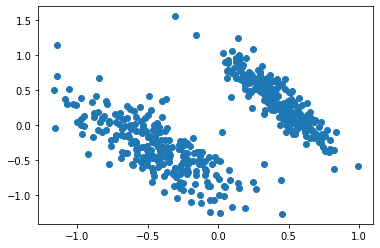

In [236]:
xx = torch.Tensor(xx)
xx = (xx-xx.mean(axis=0, keepdims=True))/xx.std(axis=0, keepdims=True)*0.5
plt.scatter(xx[:,0], xx[:,1])

In [237]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
#         A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        A = 2*(self.centers[1:]-self.centers[:-1])
        
#         c2 = self.centers.data**2
        c2 = self.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
#         invA = A.t()
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert self.inv_params is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [238]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Inverse function AE

In [372]:
dt = DistanceTransform(2, 3, p=2)
dt.centers.data += torch.randn_like(dt.centers)*0.01

tensor([[-0.4947,  0.1218],
        [-0.0949,  0.4783],
        [-0.0829, -0.5086]])


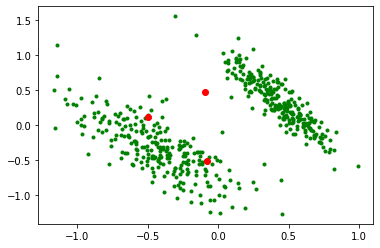

In [373]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
print(dt.centers.data)

In [374]:
dists = dt(xx)

In [375]:
dt.centers

Parameter containing:
tensor([[-0.4947,  0.1218],
        [-0.0949,  0.4783],
        [-0.0829, -0.5086]], requires_grad=True)

In [376]:
dt.compute_inverse_matrix()

In [377]:
dt.inv_params

(tensor([[ 1.2371,  0.4469],
         [ 0.0151, -0.5012]], grad_fn=<MmBackward>), tensor([[ 0.0218],
         [-0.0277]], grad_fn=<SumBackward1>))

In [378]:
dists = dists + torch.randn_like(dists)*0.1

In [379]:
xrec = dt.inverse(dists).data.cpu()

In [380]:
iclose = torch.isclose(xrec.data.cpu(), xx, atol=1e-3)
print("Not close", torch.numel(xx)-torch.count_nonzero(iclose))

Not close tensor(997)


In [381]:
### MSE
((xx-xrec)**2).mean()

tensor(0.0418)

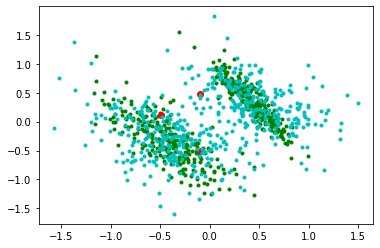

In [382]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
plt.scatter(xrec[:,0], xrec[:,1], c='c', marker='.')

## Train to reduce reconstruction error

In [266]:
SEED = -1

0


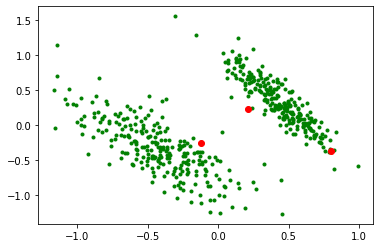

In [267]:
SEED += 1
SEED = 0
print(SEED) #0
torch.manual_seed(SEED) #18, 
# dt = DistanceTransform(2, 3, p=2)
# dt.centers.data += torch.randn_like(dt.centers)*0.01
# dt.centers.data *= 4

%matplotlib inline
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')

In [268]:
optimizer = optim.Adam(list(dt.parameters()), lr=0.01)
criterion = nn.MSELoss()

In [269]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(5000):
    
    dists = dt(xx)
    dt.compute_inverse_matrix()
    xrec = dt.inverse(dists)

    loss = criterion(xrec, xx)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if epoch%100 == 0:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        xrec = xrec.data
        
        ax.scatter(xx[:,0], xx[:,1], c='g', marker='.')
        ax.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
        ax.scatter(xrec[:,0], xrec[:,1], c='c', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)

Epoch: 0, Loss:1.3926424439645799e-14
Epoch: 100, Loss:1.6037718435181134e-14
Epoch: 200, Loss:1.823700051921135e-14
Epoch: 300, Loss:4.2325382565086556e-14
Epoch: 400, Loss:1.806619632539752e-14
Epoch: 500, Loss:1.1784314538456405e-14
Epoch: 600, Loss:1.8423119068711538e-14
Epoch: 700, Loss:7.27538367143463e-15
Epoch: 800, Loss:2.4189182354730256e-14
Epoch: 900, Loss:1.869961942181555e-14


TclError: invalid command name "pyimage440"

tensor([[-0.1223, -0.2479],
        [ 0.8028, -0.3695],
        [ 0.2105,  0.2374]])


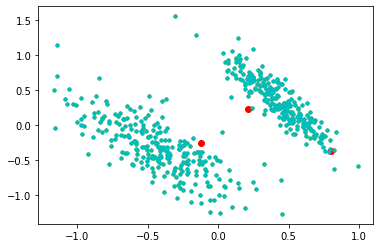

In [270]:
%matplotlib inline
fig = plt.figure()
xrec = xrec.data
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
plt.scatter(xrec[:,0], xrec[:,1], c='c', marker='.')
print(dt.centers.data)

## Inverse GD

In [383]:
## random initialization
torch.manual_seed(SEED)
XX = torch.autograd.Variable(torch.randn_like(xx)*2, requires_grad=True)
# dists = dt(xx).data

In [384]:
# dists = dists + torch.randn_like(dists)*0.1

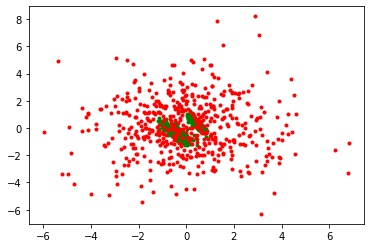

In [385]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(XX.data[:,0], XX.data[:,1], c='r', marker='.')

In [386]:
xoptim = torch.optim.Adam([XX], lr=0.01)
# criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
# criterion = nn.L1Loss()

In [387]:
def seq_criterion(yout, targ, num_cents):
    ## solve for each centroid sequentially
    error = ((dists[:, :num_cents]-yout[:, :num_cents])**2).mean()one reason why compilers will typically replace
    return error

Step: 0, error: 5.260499
Step: 100, error: 2.267595
Step: 200, error: 1.057257
Step: 300, error: 0.512855
Step: 400, error: 0.254474
Step: 500, error: 0.128457
Step: 600, error: 0.065811
Step: 700, error: 0.034058
Step: 800, error: 0.017658
Step: 900, error: 0.009079
Step: 1000, error: 0.004585
Step: 1100, error: 0.002257
Step: 1200, error: 0.001078
Step: 1300, error: 0.000499
Step: 1400, error: 0.000225
Step: 1500, error: 0.000101
Step: 1600, error: 0.000047
Step: 1700, error: 0.000025
Step: 1800, error: 0.000017
Step: 1900, error: 0.000014
Step: 2000, error: 0.000012
Step: 2100, error: 0.000012
Step: 2200, error: 0.000012
Step: 2300, error: 0.000012
Step: 2400, error: 0.018161
Step: 2500, error: 0.007342
Step: 2600, error: 0.004374
Step: 2700, error: 0.003052
Step: 2800, error: 0.002320
Step: 2900, error: 0.001916
Step: 3000, error: 0.001677
Step: 3100, error: 0.001521
Step: 3200, error: 0.001410
Step: 3300, error: 0.001325
Step: 3400, error: 0.001254
Step: 3500, error: 0.001192
Step

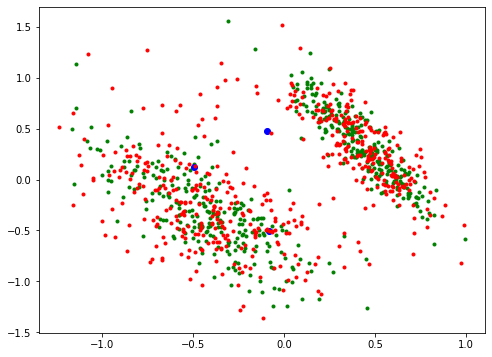

In [388]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

EPOCHS = 7000
for i in range(EPOCHS):
    yout = dt(XX)#+torch.randn_like(XX)*0.1)
#     error = criterion(yout, dists)
#     error = ((dists-yout).abs()).mean()
#     error = ((dists-yout).abs()).max(dim=1)[0].mean()
#     error = ((dists-yout)**2).max(dim=1)[0].mean()

    ### sequential loss
    error = seq_criterion(yout, dists, int(i/EPOCHS*dt.num_centers + 1))

#     error = ((dists-yout).abs().sqrt()).mean()


    xoptim.zero_grad()
    error.backward(retain_graph=True)
    xoptim.step()
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        ax.clear()
        ax.scatter(xx[:,0], xx[:,1], c='g', marker='.')
        ax.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='b', marker='o')
        ax.scatter(XX.data[:,0], XX.data[:,1], c='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)

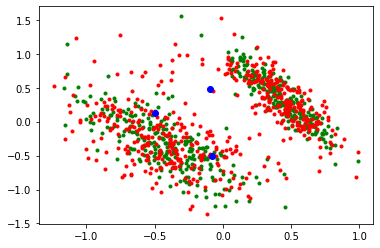

In [389]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(XX.data[:,0], XX.data[:,1], c='r', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='b', marker='o')

In [390]:
### MSE
((XX.data-xx)**2).mean()

tensor(0.0518)

### Train linear autoencoder for comparision

In [31]:
class LinearAE(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.mean = nn.Parameter(torch.zeros(input_dim))
        self.enc = nn.Linear(input_dim, hidden_dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(input_dim))
        
    def forward(self, x):
        h = self.enc(x-self.mean)
        w = self.enc.weight
#         w = torch.pinverse(self.enc.weight.t())

        xrec = torch.matmul(h, w) + self.bias
        return xrec

In [32]:
lae = LinearAE(2, 1).to(device)

In [33]:
optimizer = optim.Adam(list(lae.parameters()), lr=0.01)
criterion = nn.MSELoss()

In [34]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(5000):
    
    xrec = lae(xx)

    loss = criterion(xrec, xx)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if epoch%100 == 0:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        xrec = xrec.data
        
        ax.scatter(xx[:,0], xx[:,1], c='g', marker='.')
        ax.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
        ax.scatter(xrec[:,0], xrec[:,1], c='c', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)

Epoch: 0, Loss:0.17657732963562012
Epoch: 100, Loss:0.09297018498182297
Epoch: 200, Loss:0.0918562188744545
Epoch: 300, Loss:0.09185507148504257
Epoch: 400, Loss:0.09185511618852615
Epoch: 500, Loss:0.09185506403446198
Epoch: 600, Loss:0.09185513108968735
Epoch: 700, Loss:0.09185506403446198
Epoch: 800, Loss:0.09185511618852615


TclError: invalid command name "pyimage20"

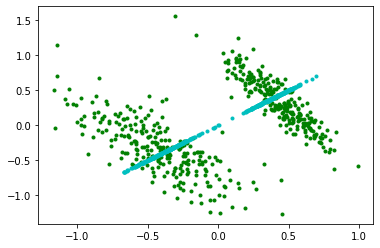

In [35]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(xrec[:,0], xrec[:,1], c='c', marker='.')

## KMeans

In [36]:
from sklearn.cluster import KMeans

In [37]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(xx)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [38]:
kc = kmeans.cluster_centers_

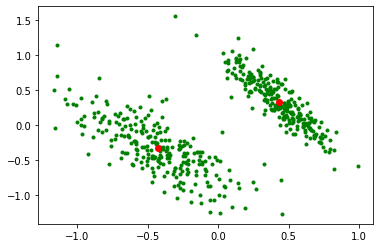

In [39]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(kc[:,0], kc[:,1], c='r', marker='o')

### Invex distance

In [99]:
# A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
gprms = np.array([[0, 2, 2.5, 5.4, 1.5],
         [-1, 4, 6, 2.5, 1.8],
         [-3, -0.5, 1, 2, 4],
         [3, 0.5, 2, 1, 5]
        ])
# gprms[:, 4] = [0.5,0.5,0.2,0.47]
gprms[:, 4] = [0.5,0.5,0.2,0.4]
gprms = torch.Tensor(gprms)

def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * torch.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)
    return A * torch.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)


def invex_func(x:torch.Tensor):
    assert x.shape[1] == 2
    x = (x*2+torch.Tensor([[-0.16088117489986598, 3.6622162883845126]]))
    yout = torch.zeros(x.shape[0], 1)
    for p in gprms:
        yout += gaussian(x[:,:1], x[:,1:], *p)
    return -(yout-0.9343677453125454)

# -0.9343704434287424
# (-0.15542072276303553, 3.6648886518202426)

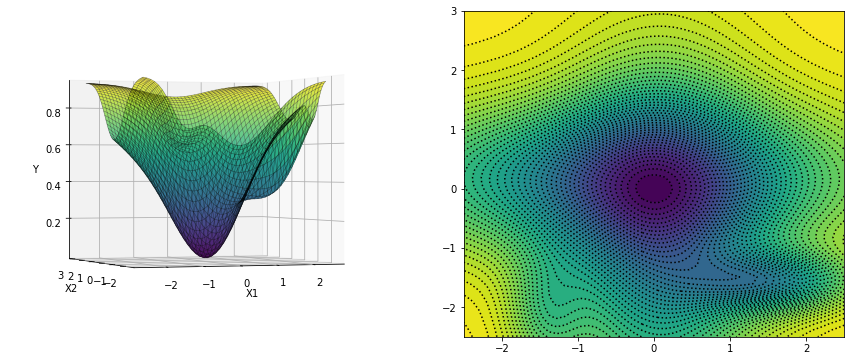

In [100]:
num_points = 50
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
X1, X2 = np.meshgrid(X1, X2)
XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

Y = invex_func(XX).data.numpy().reshape(X1.shape)

%matplotlib inline
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
ax.view_init(0, -110)

ax.plot_surface(X1, X2, Y, cmap="viridis", alpha=0.8)
ax.plot_wireframe(X1, X2, Y, alpha=0.5, lw=0.5, color='k')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

ax2.contourf(X1, X2, Y, levels=60)
ax2.contour(X1, X2, Y, levels=60, colors='k', linestyles='dotted')

# plt.pause(10)
plt.show()

### Training with distance given by this distance function

In [101]:
class InvexDT(DistanceTransform):
    
    def forward(self, x):
#         print(x.shape)
        x = x.unsqueeze(dim=1)
#         print(x.shape)
        c = self.centers
#         print(c.shape)
        c = c.unsqueeze(dim=0)
#         print(c.shape)
        cdiff = (x-c).reshape(-1, c.shape[-1])
#         print(cdiff.shape)
        dists = invex_func(cdiff)
#         print(dists.shape)
        dists = dists.reshape(x.shape[0], -1)
#         print(dists.shape)
        return dists

In [102]:
idt = InvexDT(2, 1)

In [103]:
idt(xx)

tensor([[0.3131],
        [0.2769],
        [0.1919],
        [0.3973],
        [0.1217],
        [0.2587],
        [0.3741],
        [0.4635],
        [0.3713],
        [0.3072],
        [0.0873],
        [0.2578],
        [0.2876],
        [0.2497],
        [0.0661],
        [0.3522],
        [0.0174],
        [0.0086],
        [0.3800],
        [0.4626],
        [0.5380],
        [0.6042],
        [0.5231],
        [0.4307],
        [0.1730],
        [0.2289],
        [0.3977],
        [0.3425],
        [0.0618],
        [0.3793],
        [0.5372],
        [0.4359],
        [0.3712],
        [0.0566],
        [0.0192],
        [0.1288],
        [0.3773],
        [0.3163],
        [0.3859],
        [0.2190],
        [0.3092],
        [0.3651],
        [0.3579],
        [0.3800],
        [0.0278],
        [0.5048],
        [0.3138],
        [0.1613],
        [0.3785],
        [0.4464],
        [0.5403],
        [0.3327],
        [0.3229],
        [0.2766],
        [0.1873],
        [0

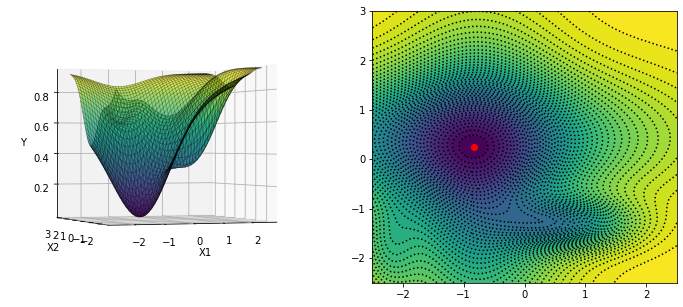

In [104]:
Y = idt(XX).data.numpy().reshape(X1.shape)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
ax.view_init(0, -110)

ax.plot_surface(X1, X2, Y, cmap="viridis", alpha=0.8)
ax.plot_wireframe(X1, X2, Y, alpha=0.5, lw=0.5, color='k')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

ax2.contourf(X1, X2, Y, levels=60)
ax2.contour(X1, X2, Y, levels=60, colors='k', linestyles='dotted')
ax2.scatter(*idt.centers.data.t(), c='r')

# plt.pause(10)
plt.show()

### Train invex DT for inverse transform

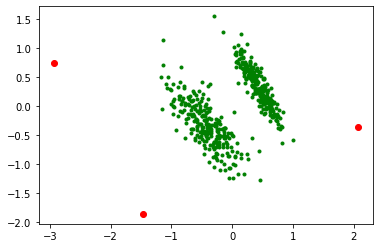

In [105]:
# idt.centers.data = (torch.rand_like(idt.centers.data)-0.5)*5

torch.manual_seed(SEED) #18, 
idt = InvexDT(2, 3)
idt.centers.data += torch.randn_like(idt.centers)*0.01
idt.centers.data *= 4

plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(idt.centers.data[:,0], idt.centers.data[:,1], c='r', marker='o')

In [106]:
idt.centers

Parameter containing:
tensor([[ 2.0708, -0.3577],
        [-2.9338,  0.7418],
        [-1.4699, -1.8575]], requires_grad=True)

In [107]:
## random initialization
XX = torch.autograd.Variable(torch.randn_like(xx)*1, requires_grad=True)
dists = idt(xx).data

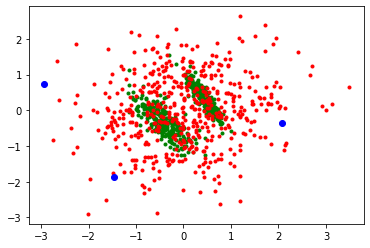

In [108]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(XX.data[:,0], XX.data[:,1], c='r', marker='.')
plt.scatter(idt.centers.data[:,0], idt.centers.data[:,1], c='b', marker='o')

In [109]:
xoptim = torch.optim.Adam([XX], lr=0.01)

Step: 0, error: 0.059945
Step: 100, error: 0.004099
Step: 200, error: 0.000438
Step: 300, error: 0.000042
Step: 400, error: 0.000010
Step: 500, error: 0.000004
Step: 600, error: 0.000002
Step: 700, error: 0.000001
Step: 800, error: 0.000000
Step: 900, error: 0.000000
Step: 1000, error: 0.000000
Step: 1100, error: 0.000000
Step: 1200, error: 0.000000
Step: 1300, error: 0.000000
Step: 1400, error: 0.000000
Step: 1500, error: 0.000000
Step: 1600, error: 0.000000
Step: 1700, error: 0.000000
Step: 1800, error: 0.000000
Step: 1900, error: 0.000000
Step: 2000, error: 0.000000
Step: 2100, error: 0.000000
Step: 2200, error: 0.000000
Step: 2300, error: 0.000000
Step: 2400, error: 0.000711
Step: 2500, error: 0.000368
Step: 2600, error: 0.000289
Step: 2700, error: 0.000257
Step: 2800, error: 0.000234
Step: 2900, error: 0.000226
Step: 3000, error: 0.000221
Step: 3100, error: 0.000217
Step: 3200, error: 0.000206
Step: 3300, error: 0.000193
Step: 3400, error: 0.000142
Step: 3500, error: 0.000118
Step

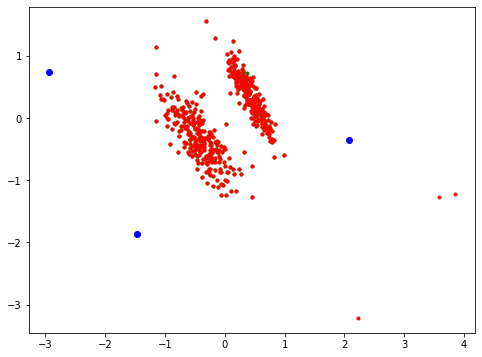

In [110]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
EPOCHS = 7000
for i in range(EPOCHS):
    yout = idt(XX)
#     error = criterion(dists, yout)
#     error = ((dists-yout).abs()).mean()
#     error = ((dists-yout)**2).max(dim=1)[0].mean()
    error = seq_criterion(yout, dists, int(i/EPOCHS*3 + 1))
    
    
    xoptim.zero_grad()
    error.backward(retain_graph=True)
    xoptim.step()
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        ax.clear()
        ax.scatter(xx[:,0], xx[:,1], c='g', marker='.')
        ax.scatter(idt.centers.data[:,0], idt.centers.data[:,1], c='b', marker='o')
        ax.scatter(XX.data[:,0], XX.data[:,1], c='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)

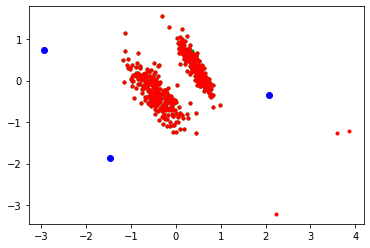

In [111]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(XX.data[:,0], XX.data[:,1], c='r', marker='.')
plt.scatter(idt.centers.data[:,0], idt.centers.data[:,1], c='b', marker='o')